## 07. LightGBM

- **부스팅** 계열 알고리즘  
- 장점
 1. XGBoost보다 **더 빠른 학습과 예측 수행 시간**
 2. 더 작은 메모리 사용량
 3. 카테고리형 피처의 자동 변환과 최적 분할(원핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행
- 단점
 : 적은 데이터 세트(10,000건 이하)에 적용할 경우 **과적합**이 발생하기 쉬움


- 일반 GBM 계열의 트리 분할 방법과는 달리 **리프 중심 트리 분할(Leaf Wise)** 방식 사용

- **균형 트리 분할(Level Wise)** : 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화될 수 있음  
→ *균형 잡힌 트리를 생성하는 이유 : 오버피팅에 보다 더 강한 구조를 가질 수 있으므로*  
→ *균형을 맞추기 위한 시간이 필요하다는 상대적인 단점 가짐*
- **리프 중심 트리 분할(Leaf Wise)** : 트리의 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리를 생성하는데 이는 학습을 반복할수록 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있음

In [ ]:
# 구글 드라이브와 연결
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


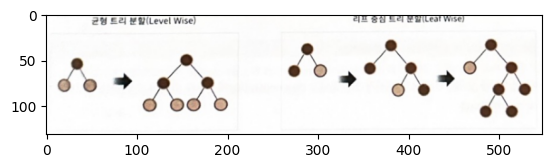

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/리프중심트리분할.PNG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### LightGBM 설치

In [ ]:
!conda installc conda-forge lightgbm

/bin/bash: conda: command not found


### LightGBM 하이퍼 파라미터

Xgboost와 다르게 리프 노드가 계속 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요함.   
(Ex. max_depth를 매우 크게 가짐)

**주요 파라미터**  
- **num_iterations [default = 100]** : 반복 수행하려는 트리의 개수를 지정함.  
→ 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 오히려 과적합으로 성능이 저하될 수 있음.  
→ LightGBM의 사이킷런 호환 클래스에서는 n_estimators로 이름이 변경됨

- **learning_rate [default = 0.1]** : 0에서 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값.  
→ 일반적으로 n_estimators를 크게 하고 learning_rate를 작게 해서 예측 성능을 향상시킬 수 있으나, 과적합 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야 함.

- **max_depth [detault = -1]** : 트리 기반 알고리즘의 max_depth와 같음. 0보다 작은 값을 지정하면 깊이에 제한이 없음.  
→ LightGBM은 Leaf wise 기반이므로 깊이가 상대적으로 더 깊음.

- **min_data_in_leaf [default = 20]** : 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며, 과적합을 제어하기 위한 파라미터.  
→ 결정 트리의 min_samples_leaf와 같은 파라미터. LightGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경됨.  

- **num_leaves [default = 31]** : 하나의 트리가 가질 수 있는 최대 리프 개수

- **boosting [default = gbdt]** : 부스팅의 트리를 생성하는 알고리즘을 기술함.  
→ *gbdt : 일반적인 그래디언트 부스팅 결정트리*  
→ *rf : 랜덤 포레스트*

- **bagging_fraction [default = 1.0]** : 트리가 커져서 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정.   
→ LightGBMClassifier에서는 subsample로 동일하게 파라미터 이름이 변경됨.

- **feature_fraction [default = 1.0]** : 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율.   
→ 과적합을 막기 위해 사용됩니다. LightGBMClassifier에서는 동일하게 coksample_bytree로 변경됨.

- **lambda_l2 [default=0.0]** : L2 regulation 제어를 위한 값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음.  
→ LightGBMClassifier에서는 reg_lambda로 변경됨.

- **lambda_l1 [default = 0.0 ]** : L1 regulation 제어를 위한 값. L2와 마찬가지로 과적합 제어를 위한 것.  
→ LightGBMClassifier에서는 reg_alpha로 변경됨

**Learning Task 파라미터**
 - **objective** : 최솟값을 가져야 할 손실함수를 정의  
 → 애플리케이션 유형. 즉 회귀, 다중 클래스 분류, 이진 분류인지에 따라서 objective인 손실함수 지정됨 

### 하이퍼 파라미터 튜닝 방안

**num_leaves의 개수**를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하며 **모델의 복잡도를 줄이는 것**이 기본 튜닝 방안

- **num_leaves** : 개별 트리가 가질 수 있는 최대 리프의 개수  
→ num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델의 복잡도가 커져 과적합 영향도가 커짐
- **min_data_in_leaf** : 과적합을 개선하기 위한 중요한 파라미터  
→ 사이킷런 래퍼 클래스에서는 min_child_samples  
→ num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지함
- **max_depth** : 명시적으로 깊이의 크기를 제한  
→ num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는데 사용

**learning_rate를 작게 하면서 n_estimators를 크게 하는 것**은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안  
→  n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있음
  
과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 **regularization**을 적용하거나 학습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용할 수 있음

### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교

사이킷런 래퍼 LightGBM 클래스와 사이킷런 래퍼 XGBoost 클래스는 **많은 하이퍼 파라미터가 똑같음**

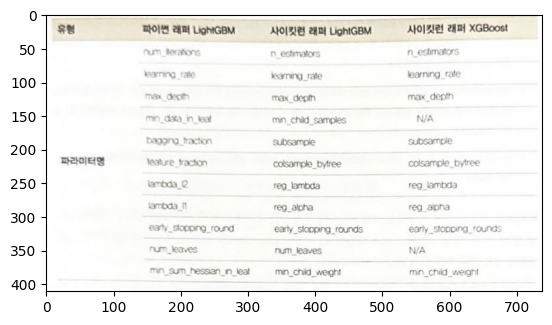

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/XGBoost와LightGBM하이퍼파라미터비교.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### LightGBM 적용 - 위스콘신 유방암 예측

In [ ]:
import lightgbm

print(lightgbm.__version__)

3.3.5


In [ ]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

조기 중단으로 111번 반복까지만 수행하고 학습을 종료함

LightGBM 모델을 기반으로 예측 성능을 평가함 → **get_clf_eval()** 함수 사용

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


정확도가 약 95.61%

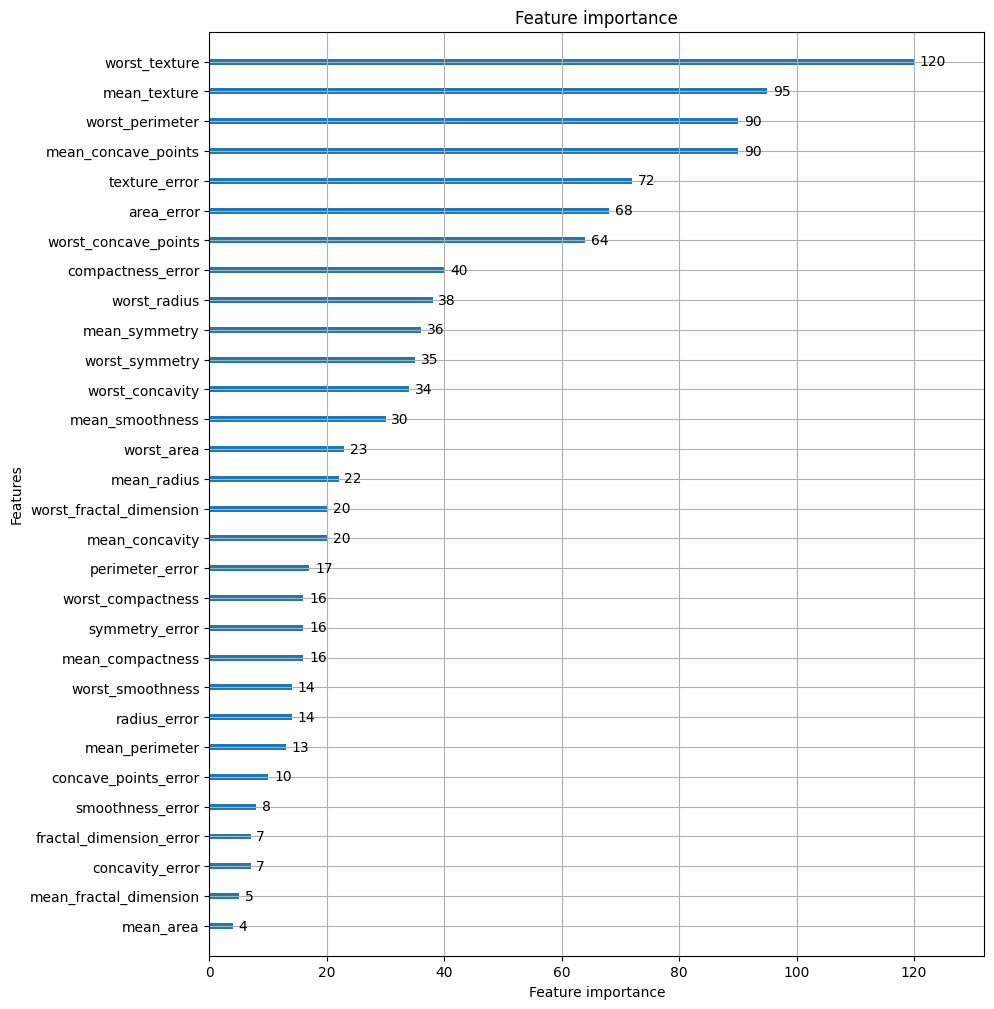

In [ ]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

## 08. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

 Grid Search 방식은 5 x 4 x 5 x 5 x 4 x 3 = 6000회에 걸쳐서 반복적으로 학습과 평가를 수행해야만 하기에 수행 시간이 매우 오래 걸릴 수밖에 없음

```
params = (
'max_depth' = [10, 20, 30, 40, 50], 'num_leaves' = [ 35, 45, 55, 65],
'colsample_bytree'= [0.5, 0.6, 0.7, 0.8, 0.9], 'subsample'= [0.5, 0.6, 0.7, 0.8, 0.9],
'min_child_weight'= [10, 20, 30, 40], reg_alpha = [0.01, 0.05, 0.1]
)
```

기하급수적으로 늘어나는 하이퍼 파라미터 최적화 시간 때문에 어쩔 수 없이 하이퍼 파라미터 개수를 줄이거나 개별 하이퍼 파라미터의 범위를 줄여야 함  
→ 때문에 실무의 대용량 학습 데이터에 XGBoost LightGBM의 하이퍼 파라미터 튜닝 시에 GridSearch 방식보다는 다른 방식을 적용

### 베이지안 최적화 개요

- **베이지안 최적화** : 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식  
→ *베이지안 확률에 기반을 두고 있는 최적화 기법*   
→ *새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나
가면서 최적 함수 모델을 만들어 냄*   

※ **함수 식 자체가 복잡하고, 입력값들의 개수가 많거나 범위가 넓은 경우**에는 입력값을 순차적으로 대입해서는 결코 짧은 시간 안에 최적 입력값을 찾을 수가 없음. 이때 **베이지안 최적화**를 이용하면 쉽고 빠르게 최적 입력값을 찾을 수 있음  

**< 베이지안 최적화를 구성하는 두 가지 중요 요소 >**  
1. **대체 모델(Surrogate Model)** : 획득 함수로부터 최적 함수를 예측할 수 있는 입력값(하이퍼 파라미터)을 추천받은 뒤 이를 기반으로 최적 함수 모델을 개선해 나감
2. **획득 함수(Acquisition Function)** : 개선된 대체 모델을 기반으로 최적 입력값을 계산  
→ 대체 모델은 획득 함수가 계산한 하이퍼 파라미터를 입력받으면서 점차적으로 개선되며, 개선된 대체 모델을 기반으로 획득 함수는 더 정확한 하이퍼 파라미터를
계산할 수 있음

**< 베이지안 최적화 단계 >**  
1. 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과를 관측.  
→ 검은색 원은 특정 하이퍼 파라미터가 입력되었을 때 관측된 성능 지표 결과값을 뜻하며 주황색 사선은 찾아야 할 목표 최적함수

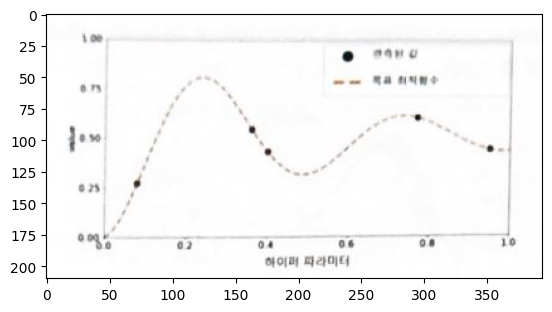

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/베이지안최적화STEP1.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

2. 관측된 값을 기반으로 대체 모델은 최적 함수를 추정  
→ 파란색 실선은 대체 모델이 추정한 최적 함수, 옅은 파란색으로 되어 있는 영역은 예측된 함수의 신뢰 구간.  
→ 추정된 함수의 결괏값 오류 편차를 의미하며 추정 함수의 불확실성을 나타냄.  
→ 최적 관측값은 y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터

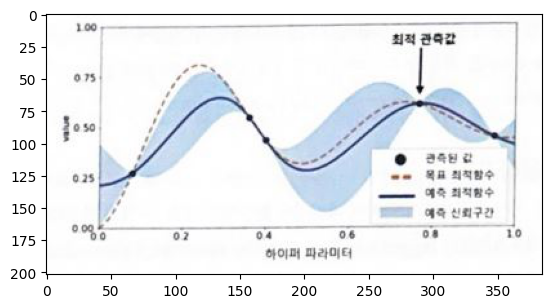

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/베이지안최적화STEP2.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

3. 추정된 최적 함수를 기반으로 획득 함수(Acquisition Function)는 다음으로 관측할 하이퍼 파라미터 값을 계산함.  
→ 획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관측할 하이퍼 파라미터를 대체 모델에 전달.

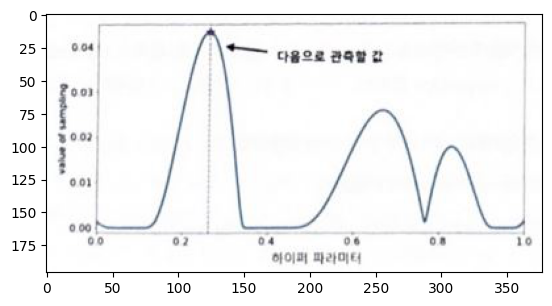

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/베이지안최적화STEP3.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

4. 획득함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델은 갱신되어 다시 최적 함수를 예측 추정

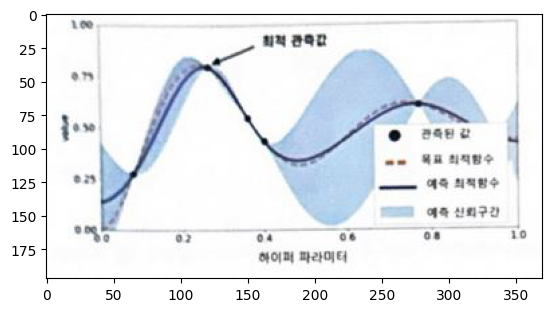

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/베이지안최적화STEP4.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

대체 모델은 최적 함수를 추정할 때 일반적으로는 가우시안 프로세스(Gaussian Process)를 적용

### HyperOpt 사용하기

HyperOpt는 가우시안 프로세스가 아닌 트리 파르젠 Estimator(TPE, Tree-structure Parzen Estimator)를 사용

베이지안 최적화를 머신러닝 모델의 하이퍼 파라미터 튜닝에 적용할 수 있게 제공되는 여러 파이썬 패키지들 중 하나

**< HyperOpt 활용하는 주요 로직 >**  
- 첫째는 입력 변수명과 입력값의 검색 공간(Search Space) 설정
- 둘째는 목적함수(Objective Function)의 설정
- 마지막으로 목적함수의 반환 최솟값을 가지는 최적 입력값을 유추하는 것  

※ HyperOpt를 사용할 때 유의할 점은 다른 패키지와 다르게 목적 함수 반환 값의 최댓값이 아닌 **최솟값을 가지는 최적 입력값을 유추한다는 것**

In [ ]:
import hyperopt

print(hyperopt.__version__)

0.2.7


HyperOpt의 hp 모듈을 이용하여 **입력 변수명과 입력값의 검색 공간을 설정**
- 입력 변수명과 입력값 검색 공간은 파이썬 딕셔너리 형태로 설정
- 키(key)값으로 입력 변수명
- 밸류(value)값으로 해당 입력 변수의 검색 공간이 주어짐

In [ ]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정. (hp.quniform은 다만 값들은 순차적으로 입력되지 않음)
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

**< 입력값의 검색 공간을 제공하는 대표적인 함수>**  
- **hp.quniform(label, low, high, a)** : Label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을 가지고 설정

- **hp.unform(label, low, high)** : 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정

- **hp.randint(label, upper)** : 0부터 최댓값 upper까지 random 한정숫값으로 검색 공간 설정.

- **hp.loguniform(label, low, high)** : exp(uniform(low, high))값을 반환하며, 반환 값의 log 변환 된 값은 정규 분포 형태를 가지는 검색 공간 설정

- **hp.choice(label, options)** : 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정 Options는 리스트나 튜플 형태로 제공되며 hp.choice('tree_criterion'. ['gini', 'entropy'])과 같이 설정하면 입력 변수 tree_criterion의 값을 'gini'와 'entropy'로 설정하여 입력함

**목적 함수를 생성**  
- **목적 함수** : 반드시 변숫값과 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환하는 구조로 만들어져야 함.

In [ ]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    
    return retval

입력값의 검색 공간과 목적 함수를 설정했으면 목적 함수의 반환값이 최소가 될 수 있는 **최적의 입력값**을 베이지안 최적화 기법에 기반해 찾아야 함  
→ **fmin(objective, space, algo, max_evals, trials) 함수**를 제공
- fn : objective_func와 같은 목적 함수

- space : search_space와 같은 검색 공간 딕셔너리

- algo: 베이지안 최적화 적용 알고리즘. 기본적으로 tpe.suggest이며 이는 HyperOpt의 기본 최적화 알고리즘인 TPE(Tree of Parzen Estimator)를 의미.

- max_evals : 최적 입력값을 찾기 위한 입력값 시도 횟수

- trials : 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는 데 사용됨. Trails 클래스를 객체로 생성한 변수명을 입력

- rstate : fmin( )을 수행할 때마다 동일한 결과값을 가질 수 있도록 설정하는 랜덤 시드(seed) 값


In [ ]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄. (일반적으로는 rstate를 잘 적용하지 않음)
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 823.28trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


확실하게 만족할 수준의 최적 x와 y값을 찾은 것은 아니지만, 5번의 수행으로 어느 정도 최적값에 다가설 수 있었다는 점은 주지할 만 함

max_evals 값을 20으로 설정하여 20번의 수행으로 반환된 최적값

In [ ]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 939.24trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


max_evals=20으로 fmin() 함수는 20회의 반복 수행을 했으므로 results 속성은 loss와 status를 키값으로 가지는 20개의 딕셔너리를 개별 원소를 가지는 리스트로 구성되어 있음

In [ ]:
# fmin( )에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환 상태값} 와 같은 딕셔너리임. 
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


Trials 객체의 vals 속성은 딕셔너리 형태로 값을 가짐  
→  fmin() 함수 수행 시마다 입력되는 입력 변숫값들을 {'입력변수명': 개별 수행 시마다 입력된 값의 리스트]와 같은 형태로 가짐

In [ ]:
# Trials 객체의 vals 속성에 {'입력변수명':개별 수행 시마다 입력된 값 리스트} 형태로 저장됨.
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


Trials 객체의 results와 vals 속성은 HyperOpt의 fmin() 함수의 수행 시마다 최적화되는 경과를 볼 수 있는 함수 반환값과 입력 변숫값들의 정보를 제공해 줌  
→ 생성된 DataFrame을 통해 좀 더 직관적으로 수행 횟수별 입력 변수 x, y와 반환값 loss를 확인할 수 있음

In [ ]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성. 
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

- 적용해야 할 하이퍼 파라미터와 검색 공간을 설정하고, 목적 함수에서 XGBoost를 학습 후에 예측 성능 결과를 반환 값으로 설정

-  fmin() 함수에서 목적 함수를 하이퍼 파라미터 검색 공간의 입력값들을 사용하여 최적의 예측 성능 결과를 반환하는 최적 입력값들을 결정하는 것

※ **주의사항**   
1. 특정 하이퍼 파라미터들은 정숫값만 입력은 받는데 HyperOpt는 입력값과 반환 값이 모두 실수형이기 때문에 하이퍼 파라미터 입력 시 형변환을 해줘야 하는 부분

2. HyperOpt의 목적 함수는 최솟값을 반환할 수 있도록 최적화해야 하기 때문에
성능 값이 클수록 좋은 성능 지표일 경우 -1을 곱해 줘야 한다는 것

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

In [ ]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
    
    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:16<00:00,  3.01trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.9599446282177103, 'learning_rate': 0.15480405522751015, 'max_depth': 6.0, 'min_child_weight': 2.0}


In [ ]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.95994, learning_rate:0.1548, max_depth:6, min_child_weight:2


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.56834	validation_1-logloss:0.60660
[1]	validation_0-logloss:0.47552	validation_1-logloss:0.54538
[2]	validation_0-logloss:0.40208	validation_1-logloss:0.48735
[3]	validation_0-logloss:0.34468	validation_1-logloss:0.45698
[4]	validation_0-logloss:0.29775	validation_1-logloss:0.41729
[5]	validation_0-logloss:0.26004	validation_1-logloss:0.39167
[6]	validation_0-logloss:0.22681	validation_1-logloss:0.36682
[7]	validation_0-logloss:0.20096	validation_1-logloss:0.34593
[8]	validation_0-logloss:0.17762	validation_1-logloss:0.33030
[9]	validation_0-logloss:0.15762	validation_1-logloss:0.31918
[10]	validation_0-logloss:0.14233	validation_1-logloss:0.30772
[11]	validation_0-logloss:0.12769	validation_1-logloss:0.30104
[12]	validation_0-logloss:0.11566	validation_1-logloss:0.29621
[13]	validation_0-logloss:0.10479	validation_1-logloss:0.29157
[14]	validation_0-logloss:0.09640	validation_1-logloss:0.28495
[15]	validation_0-logloss:0.08707	validation_1-logloss:0.28055
[1

## 09. 분류 실습 - 캐글 산탄데르 고객 만족 예측

### 데이터 전처리

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

cust_df = pd.read_csv("/content/drive/My Drive/CUAI_BASIC/santander-customer-satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3 칼럼의 경우 min 값이 -999999 ← NaN이나 특정 예외 값을 -99999로 변환됨  
print(cust_df var3_value_counts( )[:101)로 var 의 값을 조사해 보면 -999999 값이 116개가 있음을 알 수 있음

In [ ]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [ ]:
# var3 피처 값 대체 및 ID 피처 드롭 (-99999은 다른 값에 비해 너무 편차가 심하므로 가장 값이 많은 2로 변환 / ID 피처는 단순 식별자 이므로 드롭)
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
# X_train, y_train을 다시 학습과 검증 데이터 세트로 분리. 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.3, random_state=0)

### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, learning_rate 0.05, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82179	validation_1-auc:0.80068
[1]	validation_0-auc:0.82347	validation_1-auc:0.80523
[2]	validation_0-auc:0.83178	validation_1-auc:0.81097
[3]	validation_0-auc:0.83401	validation_1-auc:0.81091
[4]	validation_0-auc:0.83443	validation_1-auc:0.81040
[5]	validation_0-auc:0.83570	validation_1-auc:0.81089
[6]	validation_0-auc:0.83597	validation_1-auc:0.81057
[7]	validation_0-auc:0.83643	validation_1-auc:0.81082
[8]	validation_0-auc:0.83682	validation_1-auc:0.81147
[9]	validation_0-auc:0.83769	validation_1-auc:0.81188
[10]	validation_0-auc:0.83770	validation_1-auc:0.81163
[11]	validation_0-auc:0.83911	validation_1-auc:0.81355
[12]	validation_0-auc:0.83976	validation_1-auc:0.81336
[13]	validation_0-auc:0.84038	validation_1-auc:0.81365
[14]	validation_0-auc:0.84176	validation_1-auc:0.81419
[15]	validation_0-auc:0.84306	validation_1-auc:0.81586
[16]	validation_0-auc:0.84343	validation_1-auc:0.81610
[17]	validation_0-auc:0.84373	validation_1-auc:0.81584
[18]	validation_0-au

 HyperOpt를 이용해 베이지안 최적화 기반으로 XGBoost의 하이퍼 파라미터 튜닝을 수행

In [ ]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색. 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# 목적 함수 설정. 
# 추후 fmin()에서 입력된 search_space값으로 XGBClassifier 교차 검증 학습 후 -1* roc_auc 평균 값을 반환.  
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate']
                           )
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric='auc',
                   eval_set=[(X_tr, y_tr), (X_val, y_val)])
    
        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음. 
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
        
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환. 
    return -1 * np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[49]	validation_0-auc:0.88082	validation_1-auc:0.83683
[50]	validation_0-auc:0.88113	validation_1-auc:0.83650
[51]	validation_0-auc:0.88146	validation_1-auc:0.83675
[52]	validation_0-auc:0.88162	validation_1-auc:0.83679
[53]	validation_0-auc:0.88203	validation_1-auc:0.83684
[54]	validation_0-auc:0.88234	validation_1-auc:0.83717
[55]	validation_0-auc:0.88278	validation_1-auc:0.83740
[56]	validation_0-auc:0.88339	validation_1-auc:0.83711
[57]	validation_0-auc:0.88377	validation_1-auc:0.83713
[58]	validation_0-auc:0.88417	validation_1-auc:0.83752
[59]	validation_0-auc:0.88435	validation_1-auc:0.83791
[60]	validation_0-auc:0.88461	validation_1-auc:0.83800
[61]	validation_0-auc:0.88472	validation_1-auc:0.83797
[62]	validation_0-auc:0.88520	validation_1-auc:0.83803
[63]	validation_0-auc:0.88576	validation_1-auc:0.83774
[64]	validation_0-auc:0.88601	validation_1-auc:0.83751
[65]	validation_0-auc:0.88650	validation_1-auc:0.83746
[66]	validation_0-auc:0.88734

colsamplbe_bytree가 약 0.5749, learning_rate가 약 0.1514, max_depth는 5.0, min_child_weight는 6.0이 도출됨  

도출된 최적 하이퍼 파라미터를 기반으로 XGBClassifier를 재학습시키고 테스트 데이터 세트에서 ROC AUC를 측정  
(n_estimators는 500으로 증가)

In [ ]:
# n_estimators를 500 증가 후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행.
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']),
                        min_child_weight=int(best['min_child_weight']),
                        colsample_bytree=round(best['colsample_bytree'], 5)
                       )
# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_tr, y_tr), (X_val, y_val)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81735	validation_1-auc:0.80116
[1]	validation_0-auc:0.81347	validation_1-auc:0.79589
[2]	validation_0-auc:0.83192	validation_1-auc:0.81522
[3]	validation_0-auc:0.83489	validation_1-auc:0.81781
[4]	validation_0-auc:0.83767	validation_1-auc:0.82023
[5]	validation_0-auc:0.83624	validation_1-auc:0.81841
[6]	validation_0-auc:0.83829	validation_1-auc:0.81960
[7]	validation_0-auc:0.84195	validation_1-auc:0.82164
[8]	validation_0-auc:0.84463	validation_1-auc:0.82456
[9]	validation_0-auc:0.84417	validation_1-auc:0.82408
[10]	validation_0-auc:0.84326	validation_1-auc:0.82277
[11]	validation_0-auc:0.84698	validation_1-auc:0.82478
[12]	validation_0-auc:0.85045	validation_1-auc:0.82655
[13]	validation_0-auc:0.85216	validation_1-auc:0.82724
[14]	validation_0-auc:0.85307	validation_1-auc:0.82685
[15]	validation_0-auc:0.85266	validation_1-auc:0.82719
[16]	validation_0-auc:0.85238	validation_1-auc:0.82694
[17]	validation_0-auc:0.85128	validation_1-auc:0.82580
[18]	validation_0-au

하이퍼 파라미터 튜닝 이후 ROC-AUC가 개선됨

튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타냄

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

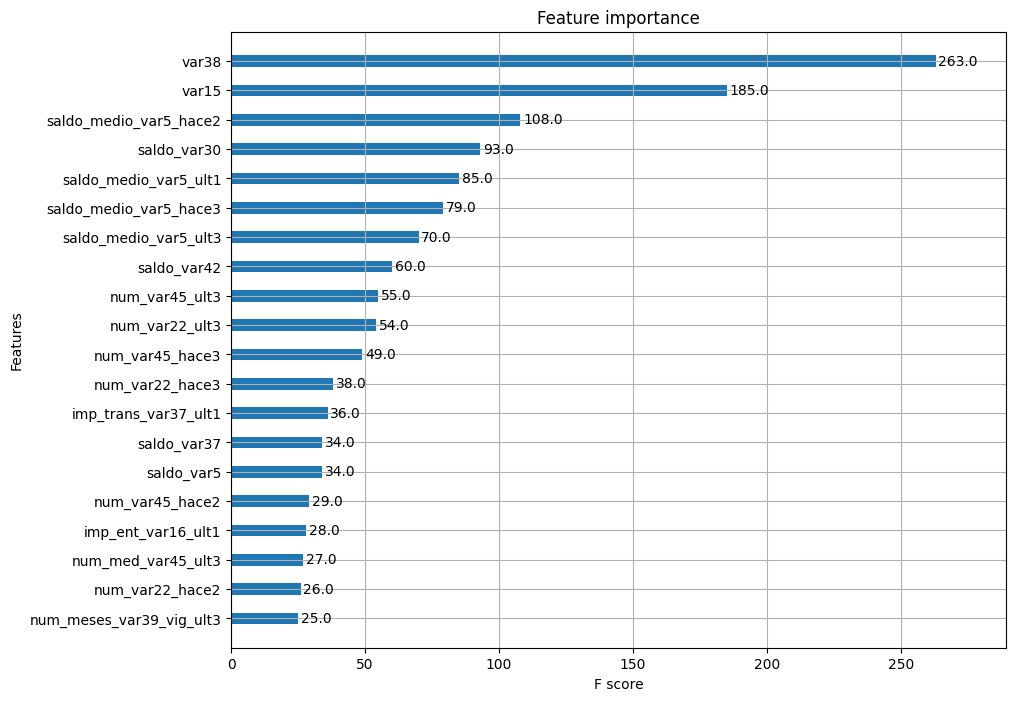

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

 XGBoost 예제 코드에서 만들어진 데이터 세트를 기반으로 LightGBM으로 학습을 수행하고, ROC-AUC를 측정

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	training's auc: 0.82625	training's binary_logloss: 0.15523	valid_1's auc: 0.809814	valid_1's binary_logloss: 0.15774
[2]	training's auc: 0.833899	training's binary_logloss: 0.149581	valid_1's auc: 0.81222	valid_1's binary_logloss: 0.153275
[3]	training's auc: 0.841789	training's binary_logloss: 0.145416	valid_1's auc: 0.814833	valid_1's binary_logloss: 0.149999
[4]	training's auc: 0.847243	training's binary_logloss: 0.14212	valid_1's auc: 0.819406	valid_1's binary_logloss: 0.147524
[5]	training's auc: 0.849589	training's binary_logloss: 0.139438	valid_1's auc: 0.821869	valid_1's binary_logloss: 0.145464
[6]	training's auc: 0.853413	training's binary_logloss: 0.137254	valid_1's auc: 0.820878	valid_1's binary_logloss: 0.143973
[7]	training's auc: 0.85551	training's binary_logloss: 0.1354	valid_1's auc: 0.821815	valid_1's binary_logloss: 0.142746
[8]	training's auc: 0.858698	training's binary_logloss: 0.133561	valid_1's auc: 0.823733	valid_1's binary_logloss: 0.141592
[9]	training's a

In [ ]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

In [ ]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1]) 
        roc_auc_list.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials

trials = Trials()

# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출. 
best = fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[33]	training's auc: 0.865947	training's binary_logloss: 0.132946	valid_1's auc: 0.834455	valid_1's binary_logloss: 0.134082
[34]	training's auc: 0.866643	training's binary_logloss: 0.132594	valid_1's auc: 0.834263	valid_1's binary_logloss: 0.133917
[35]	training's auc: 0.867039	training's binary_logloss: 0.132244	valid_1's auc: 0.834065	valid_1's binary_logloss: 0.133757
[36]	training's auc: 0.867594	training's binary_logloss: 0.131924	valid_1's auc: 0.834047	valid_1's binary_logloss: 0.133584
[37]	training's auc: 0.867958	training's binary_logloss: 0.131609	valid_1's auc: 0.833964	valid_1's binary_logloss: 0.133434
[38]	training's auc: 0.868194	training's binary_logloss: 0.1313	valid_1's auc: 0.834059	valid_1's binary_logloss: 0.133245
[39]	training's auc: 0.868599	training's binary_logloss: 0.13101	valid_1's auc: 0.834103	valid_1's binary_logloss: 0.133097
[40]	training's auc: 0.868975	training's binary_logloss: 0.130738	valid_1's auc: 0.834077	va

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators-500, num_leaves=int(best['num_leaves']),
                        max_depth = int(best['max_depth']),
                        min_child_samples = int(best['min_child_samples']),
                        subsample = round(best['subsample'], 5),
                        learning_rate = round(best['learning_rate'], 5)
                        )
# evaluation metric을 auc로, early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=100,
            eval_metric="auc",eval_set=[(X_tr, y_tr), (X_val, y_val)])
lgbm_roc_score = roc_auc_score(y_test, xgb_c1f.predict_proba(X_test)[:1])
print('ROC AUC: {0:4f}'.format(lgbm_roc_score))

NameError: ignored

## 10. 분류 실습 - 캐글 신용카드 사기 검출

사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적을 수밖에 없기 때문에 레이블 값이 극도로 불균형한 분포를 가지기 쉬움

### 언더 샘플링과 오버 샘플링의 이해

이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면에 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움

**레이블 값 분포로 인한 문제점을 해결하기 위해서 적절한 학습 데이터를 확보하는 방안**  
1. **오버 샘플링** : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법  
→  동일한 데이터를 단순히 증식하는 방법은 과적합(Overlitting)이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식함  
→  대표적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법 존재

2. **언더 샘플링** : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식  
→  정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여 버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시켜서 정상 레이블의 경우 제대로 된 학습을 수행할 수 없는 문제가 발생할 수도 있으므로 유의해야 함
  
→ 오버 샘플링 방식이 예측 성능상 조금 유리한 경우가 많아 상대적으로 더 많이 사용됨

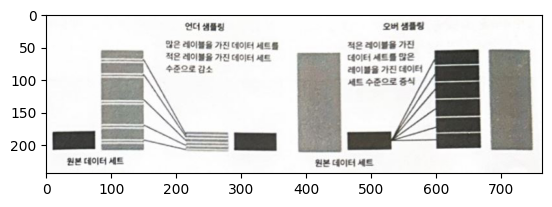

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/언더샘플링과오버샘플링.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

※ **SMOTE** : 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 아웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식  
→ 파이썬 패키지 : imbalanced-learn

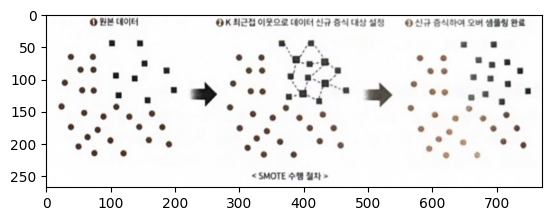

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/SMOTE방식.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### 데이터 일차 가공 및 모델 학습/예측/평가

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/My Drive/CUAI_BASIC/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

테스트 데이터세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터세트와 테스트 데이터세트의 레이블 값 분포도를 서로 동일하게 만듦

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [ ]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

 로지스틱 회귀를 이용해 신용 카드 사기 여부를 예측

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용하여 평가 수행. 
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9592


극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 함

In [ ]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


재현율 0.7568, ROC-AUC 0.9790으로 앞의 로지스틱 회귀보다는 높은 수치를 나타냄

### 데이터 분포도 변환 후 모델 학습/예측/평가

creditcard.csv의 중요 피처 값인 Amount 피처의 분포도

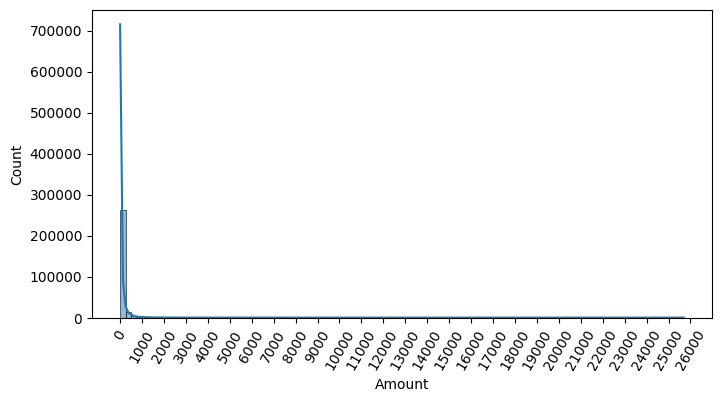

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

카드 사용금액이 1000불 이하인 데이터가 대부분이며, 26,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있음

In [ ]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용하여 정규분포 형태로 Amount 피처값 변환하는 로직으로 수정. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrame맨 앞 컬럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

함수를 수정한 후 get_train_test_dataset( )를 호출해 학습/테스트 데이터 세트를 생성한 후에 get_model_train_eval( )를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가

In [ ]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행. 
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀의 경우는 정밀도와 재현율이 오히려 조금 저하되었고, LightGM의 경우는 약간 정밀도와 재현율이 저하되었지만 큰 성능상의 변경은 없음

 Standardscaler가 아니라 로그 변환을 수행
 - **로그 변환** : 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나  
 →  원래 값을 Log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선

In [ ]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    # 넘파이의 log1p( )를 이용하여 Amount를 로그 변환 
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


로지스틱 회귀의 경우 원본 데이터 대비 정밀도 향상되었지만 재현율은 저하되었고, LightGBM의 경우 재현율이 향상됨  
→  레이블이 극도로 불균일한 데이터 세트에서 로지스틱 회귀는 데이터 변환 시 약간은 불안정한 성능 결과를 보여줌

### 이상치 데이터 제거 후 모델 학습/예측/평가

**이상치 데이터(Outlier)** : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터

- 이상치 찾는 방법  
→ IQR : 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot)
방식으로 시각화할 수 있음  
(25% 구간인 Q1 ~ 75% 구간인 Q3의 범위)  
→  IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것

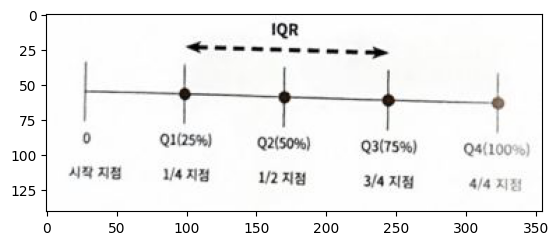

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/IQR.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

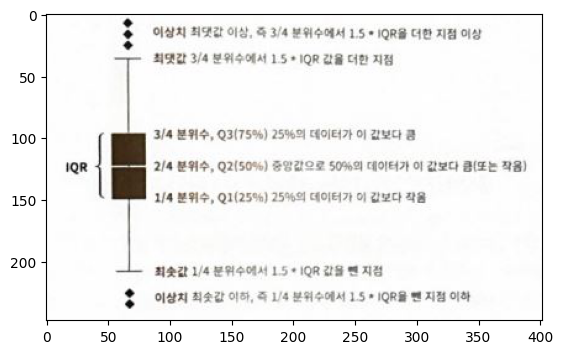

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/IQR이상치구하는법.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

상관관계 히트맵에서 cmap RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현됨

<Axes: >

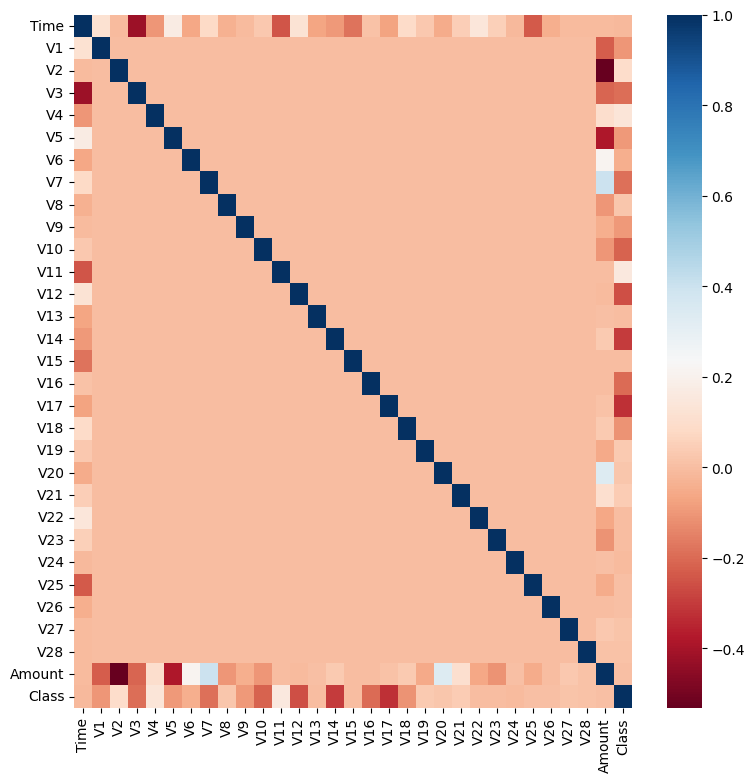

In [ ]:
import seaborn as sns

plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [ ]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상됨

### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가  
→ SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야 함

In [ ]:
#conda install -c conda-forge imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398,040건으로 데이터가 증식됨

In [ ]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하됨  
→ 재현율이 높더라도 너무 저조한 정밀도로는 현실 업무에 적용할 수 없음

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

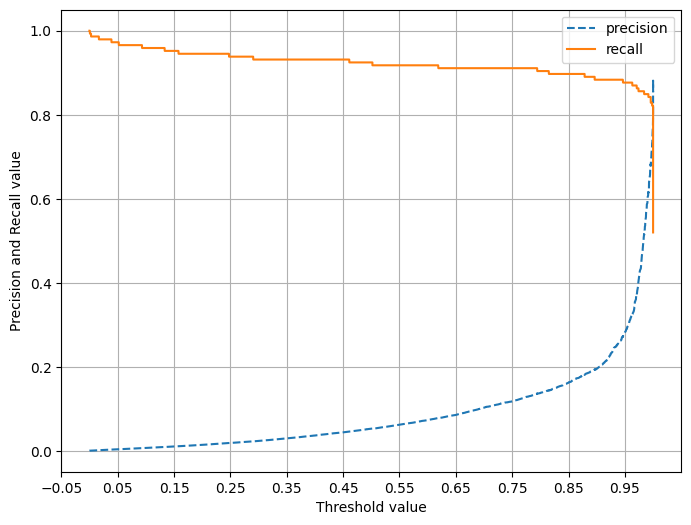

In [ ]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

- 임계값이 0.99 이하에선 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에선 반대로 재현율이 대폭 떨어지고 정밀도가 높아짐.  
- 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못함

 **LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행**

In [ ]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


재현율이 이상치만 제거한 경우인 82.88%보다 높은 84.93%가 됨.  
그러나 정밀도는 이전의 96.03%보다 낮은 91.18%임.  
→ SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적.  
때문에 **정밀도 지표보다는 재현율 지표를 높이는 것**이 머신러닝 모델의 주요한 목표인 경우 **SMOTE** 적용  
→ 좋은 SMOTE 패키지일수록 재현을 증가율은 높이고 정밀도 감소율
은 낮출 수 있도록 효과적으로 데이터를 증식

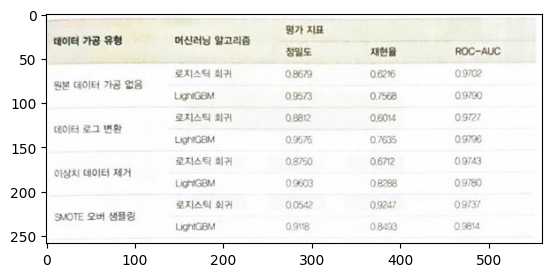

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/로지스틱회귀와LightGBM적용결과.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

## 11. 스태킹 앙상블

- **스태킹(Stacking)** : 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식  
(**메타 모델** : 개별 모델의 예측된 데이터 세트를 다시 기반으로 하여 학습하고 예측하는 방식)

→ 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 배깅(Bagging) 및 부스팅(Boosting)과 공통점을 가짐.  
가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것

**< 스태킹 모델의 종류 >**
1. 개별적인 기반 모델
2. 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
  
※ **스태킹 모델의 핵심**  
: 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것  

→ 스태킹을 적용할 때는 많은 개별 모델이 필요함. 2~3개의 개별 모델만을 결합해서는 쉽게 예측 성능을 향상시킬 수 없으며, 스태킹을 적용한다고 해서 반드시 성능 향상이 되리라는 보장도 없음. 일반적으로 성능이 비슷한 모델을 결합해 좀 더 나은 성능 향상을 도출하기 위해 적용됨

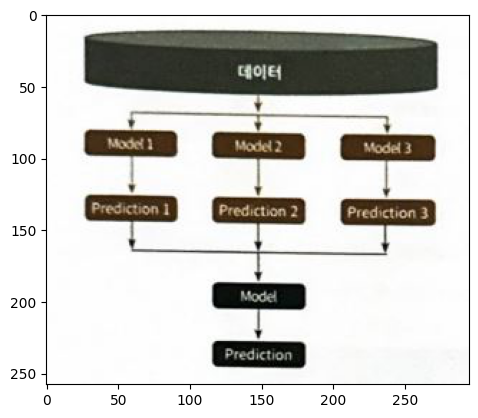

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/스태킹모델.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- **스태킹 앙상블 모델** : 먼저 모델별로 각각 학습을 시킨 뒤 예측
을 수행하면 각각 M개의 로우를 가진 1개의 레이블 값을 도출. 모델별로 도출된 예측 레이블 값을 다시 합해서(스태킹) 새로운 데이터 세트를 만들고 이렇게 스태킹된 데이터 세트에 대해 최종 모델을 적용해 최종 예측을 하는 것

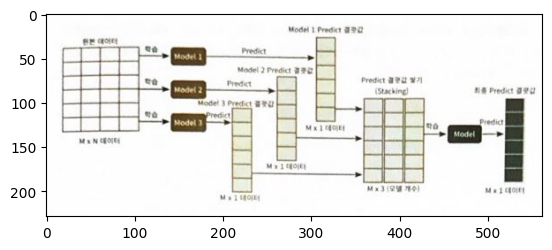

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/스태킹앙상블모델.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

### 기본 스태킹 모델

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

In [ ]:
# 개별 ML 모델을 위한 Classifier 생성. (개별모델은 KNN, 랜덤 포레스트, 결정 트리, 에이타부스트)
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. (최종 모델은 로지스틱 회귀)
lr_final = LogisticRegression(C=10)

In [ ]:
# 개별 모델들을 학습. 
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 :


In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


개별 모델의 예측 데이터를 스태킹으로 재구성해 최종 메타 모델에서 학습하고 예측한 결과, 정확도가 97.37%로 개별 모델 정확도보다 향상됨

### CV 세트 기반의 스태킹

- **CV 세트 기반의 스태킹 모델**  
: 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용

1. 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성

2. 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성.  
마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성. 

  
→ 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이
블 데이터를 기반으로 학습한 뒤 최종적으로 생성된 테스트 데이터 세트를 예측하고 원본 테스트 데이터의 레이블 데이터를 기반으로 평가함

**3개의 폴드만큼 반복을 수행하면서 스태킹 데이터를 생성하는 첫 번째 반복**

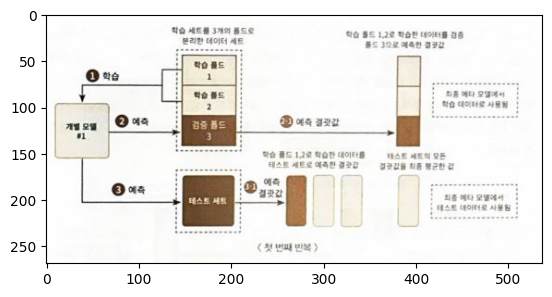

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/첫번째반복.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

**스태킹 데이터를 생성하는 두 번째 반복** (폴드 내의 학습용 데이터 세트를 변경하고 첫 번째와 동일한 작업 수행)

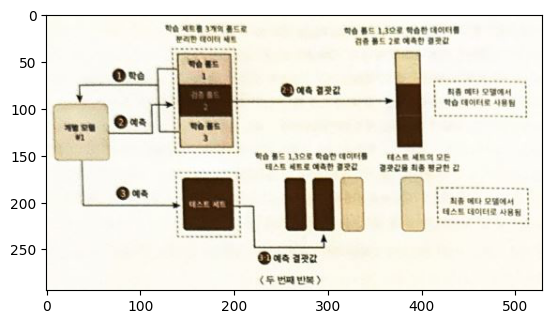

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/두번째반복.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

**스태킹 데이터를 생성하는 세 번째 반복** (세 번째 반복을 수행하면서 폴드 내의 학습용 데이터 세트가 변경됨)

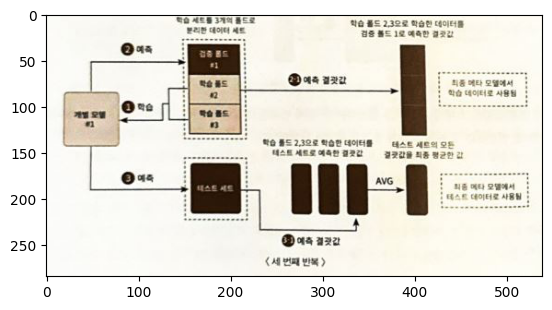

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/세번째반복.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

- 각 모델들이 스텝 1로 생성한 학습과 테스트데이터를 모두 합쳐서 최종적으로 메타모델이 사용할 학습데이터와 테스트데이터를 생성하는 스텝 2  

- 메타 모델이 사용할 최종 학습 데이터와 원본 데이터의 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측을 수행한 뒤, 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가

**CV 기반의 스태킹 모델 전체 도식화**

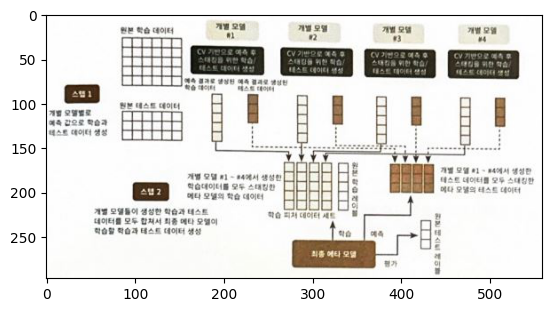

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

img = imread('/content/drive/My Drive/CUAI_BASIC/전체도식화.JPG')         # 이미지 읽어오기(적절한 경로를 설정해야 함)

plt.imshow(img)                                                               # 읽어온 이미지 표시
plt.show()

**스텝 1** : 개별 모델이 메타 모델을 위한 학습용 데이터와 테스트 데이터를 생성하는 것

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 


**스텝 2** : get_stacking_base_datasets( ) 호출로 반환된 각 모델별 학습 데이터와 테스트 데이터를 합치기만 하면 됨.  
→ 넘파이의 concatenate( )를 이용해 쉽게 이와 같은 기능을 수행

In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


- **Stack_final_X_train** : 메타 모델이 학습할 학습용 피처 데이터 세트  
- **Stack_final_X_test** : 메타 모델이 예측할 테스트용 피처 데이터 세트
  
→  스태킹 학습피처 데이터는 원본 학습피처 데이터와 로우(Row) 크기는 같으며, 4개의 개별 모델 예측값을 합친 것이므로 칼럼(Column) 크기는 4
  

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


최종 메타 모델의 예측 정확도는 약 98.25%로 측정됨.

**스태킹 모델의 파라미터 튜닝** : 개별 알고리즘 모델의 파라미터를 최적으로 튜닝하는 것  
→ 분류(Classification)뿐만 아니라 회귀(Regression)에도 적용 가능